# Introduction

This notebook demonstrates how to use a LSTM-based Variational Autocoder to classifiy workloads

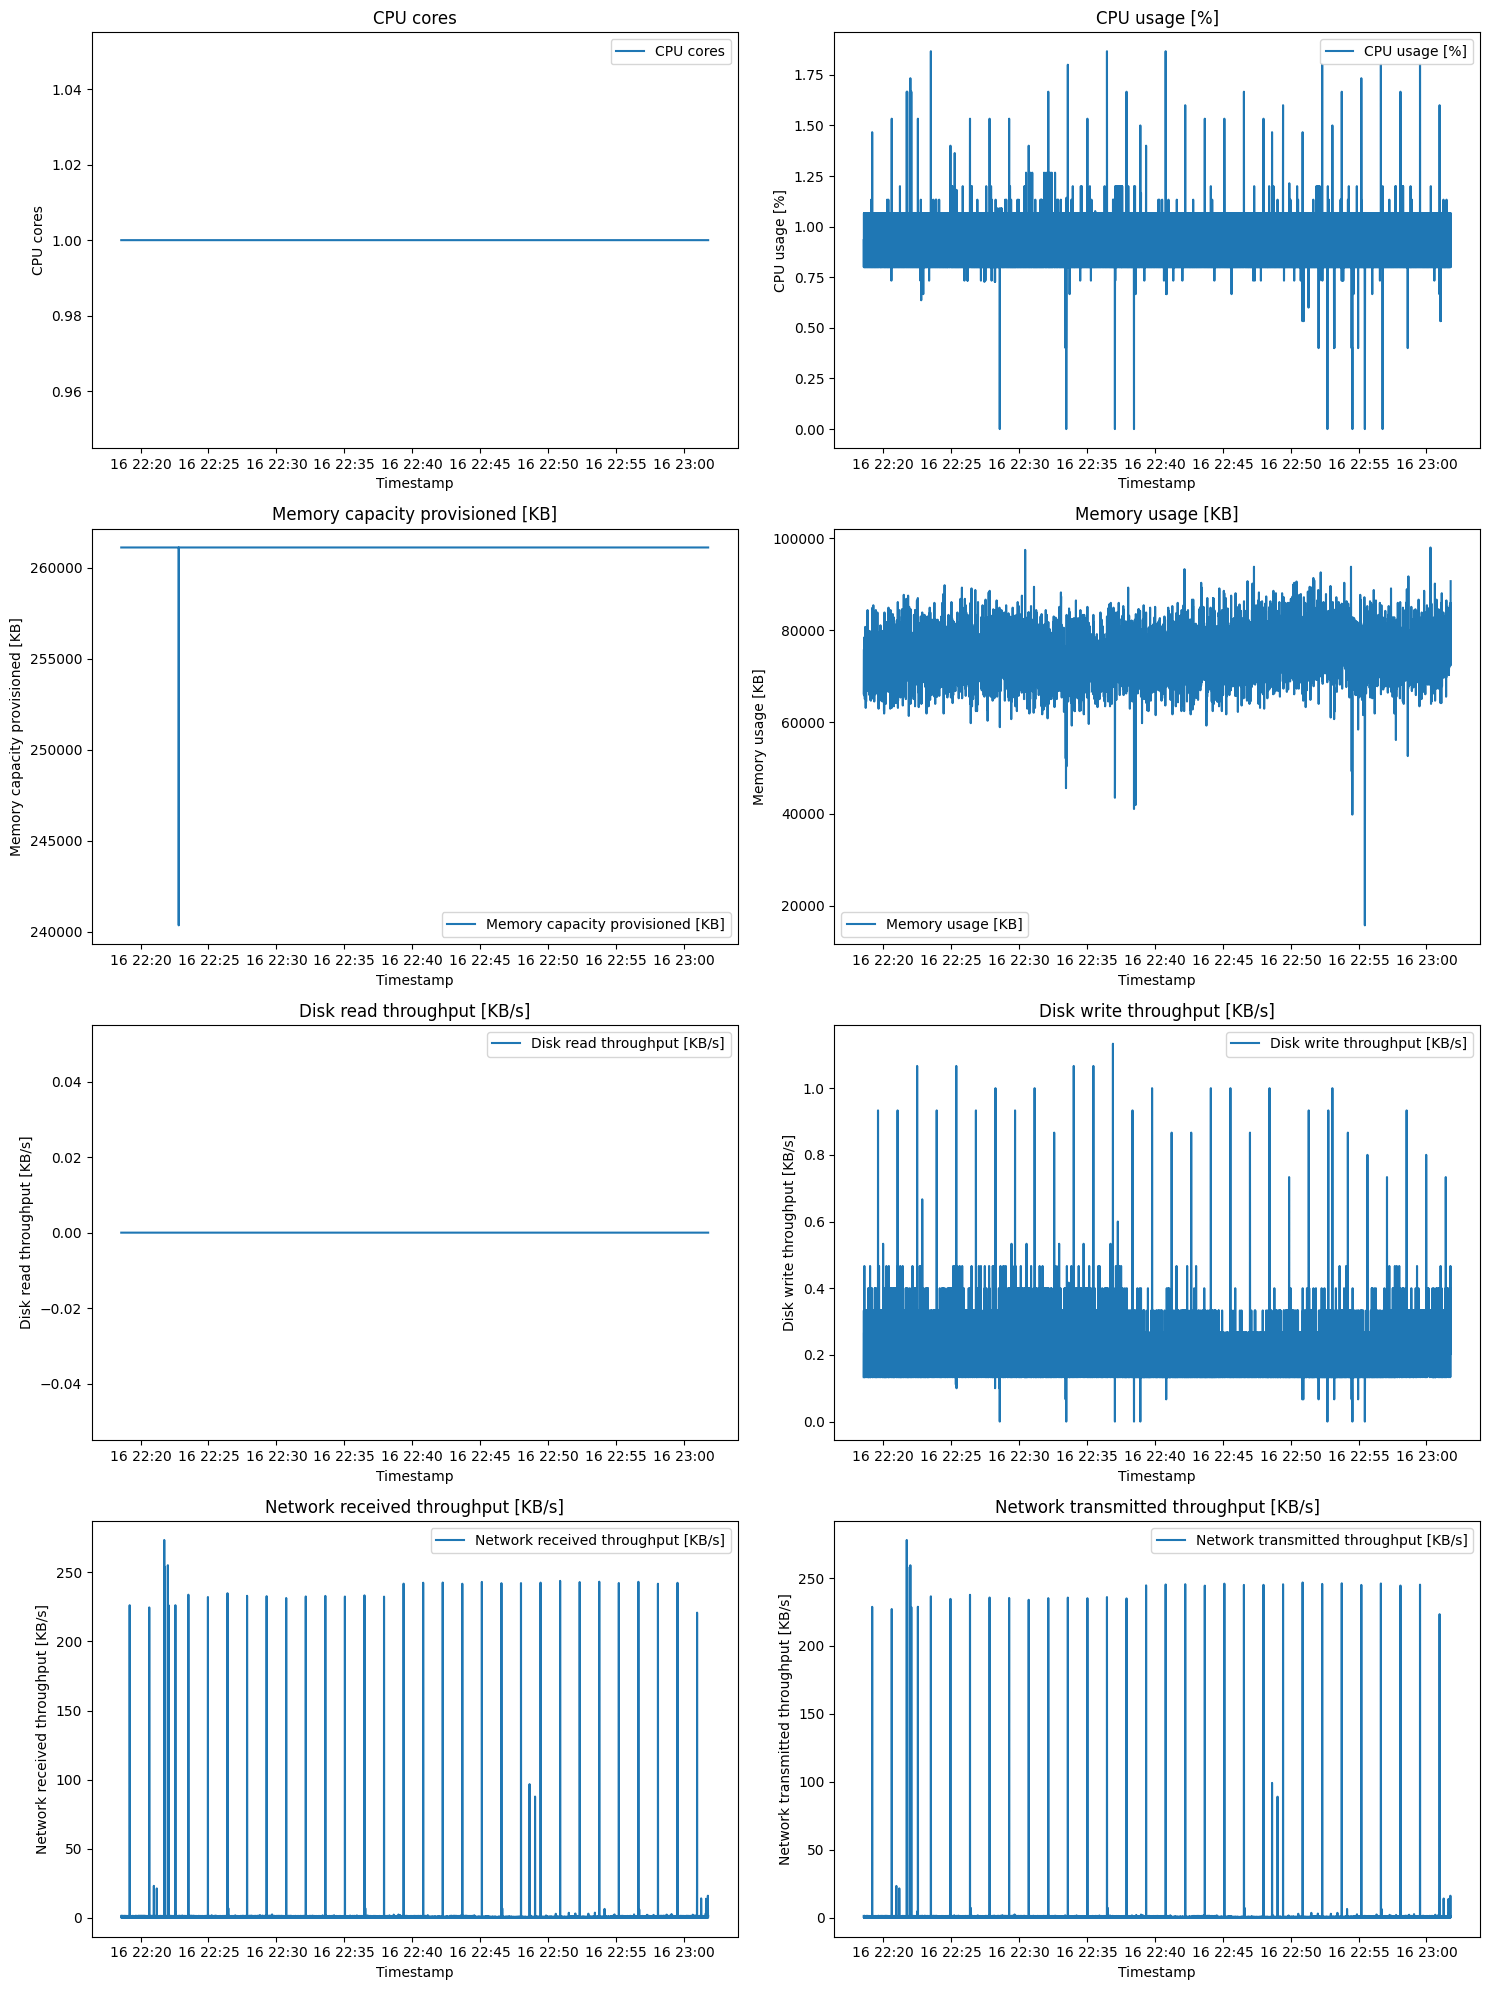

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/notebooks/fastStorage/2013-8/1050.csv'

df = pd.read_csv(file_path, delimiter=';')
df.columns = df.columns.str.strip()
df['Timestamp [ms]'] = pd.to_datetime(df['Timestamp [ms]'], unit='ms')

columns_to_plot = ['CPU cores', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 
                   'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 
                   'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]']

nrows = len(columns_to_plot) // 2 + len(columns_to_plot) % 2
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
for i, column in enumerate(columns_to_plot):
    ax = axs[i // ncols, i % ncols]
    ax.plot(df['Timestamp [ms]'], df[column], label=column)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(column)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

## Preprocessing and dataset generation

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

def lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    if data.shape[0] > order * 3:
        y = filtfilt(b, a, data, axis=0)
    else:
        y = data
    return y

def load_data(file_paths, time_steps, cutoff_frequency, sampling_rate, filter_order, window_size):
    data_list = []
    global_min = None
    global_max = None

    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter=';')
        df = df[['\tCPU usage [%]', '\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]', '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]']]
        df.fillna(0, inplace=True) 

        filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
        df_filtered = pd.DataFrame(filtered_data, columns=df.columns)

        df_moving_average = df_filtered.rolling(window=window_size, min_periods=1).mean()

        local_min = df_moving_average.min().min()
        local_max = df_moving_average.max().max()
        
        if global_min is None or global_max is None:
            global_min = local_min
            global_max = local_max
        else:
            global_min = min(global_min, local_min)
            global_max = max(global_max, local_max)

    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter=';')
        df = df[['\tCPU usage [%]', '\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]', '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]']]
        df.fillna(0, inplace=True) 

        filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
        df_filtered = pd.DataFrame(filtered_data, columns=df.columns)
        df_moving_average = df_filtered.rolling(window=window_size, min_periods=1).mean()

        df_normalized = (df_moving_average - global_min) / (global_max - global_min)
        df_normalized = np.clip(df_normalized, 0, 1)

        data_list.append(df_normalized.values)

    all_data = np.concatenate(data_list, axis=0)
    num_samples = all_data.shape[0] // time_steps
    all_data = all_data[:num_samples * time_steps]
    data_reshaped = all_data.reshape((num_samples, time_steps, -1))

    return torch.tensor(data_reshaped, dtype=torch.float32)

num_features = 6
time_steps = 5000
file_paths = ['/notebooks/fastStorage/2013-8/{}.csv'.format(i) for i in range(1, 1250)]
cutoff_frequency = 0.1
sampling_rate = 1
filter_order = 5
window_size = 80

data_tensor = load_data(file_paths, time_steps, cutoff_frequency, sampling_rate, filter_order, window_size)
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

print(f"Data tensor shape: {data_tensor.shape}")

Data tensor shape: torch.Size([2242, 5000, 6])


## Plot some examples from the dataset

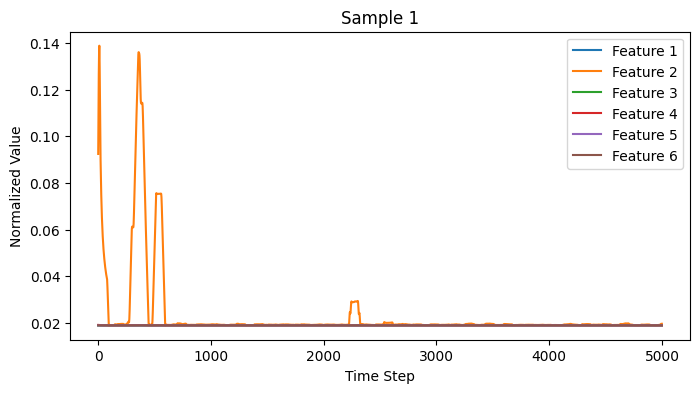

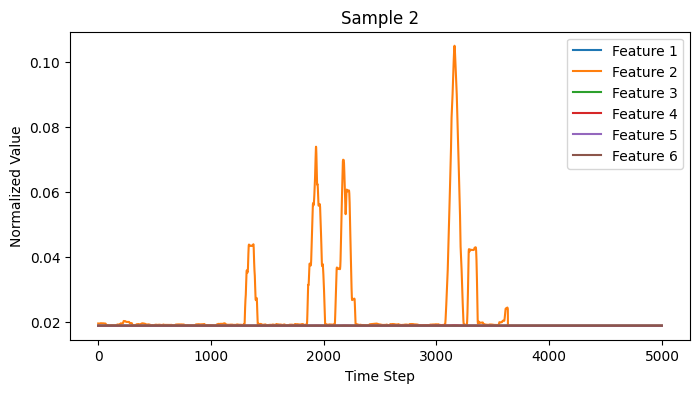

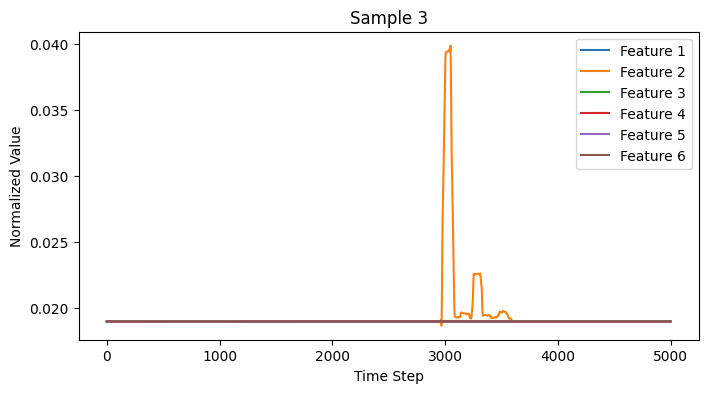

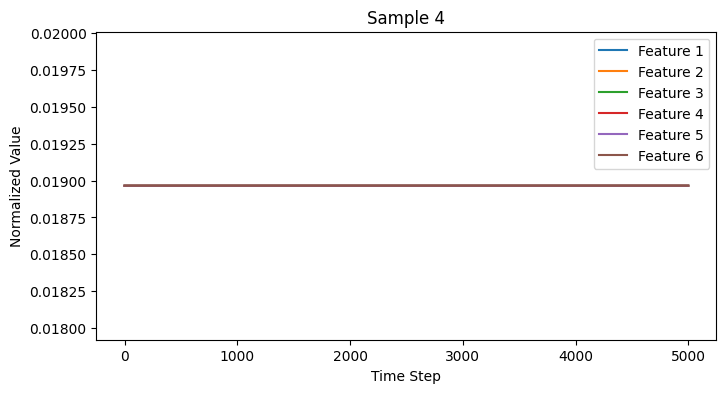

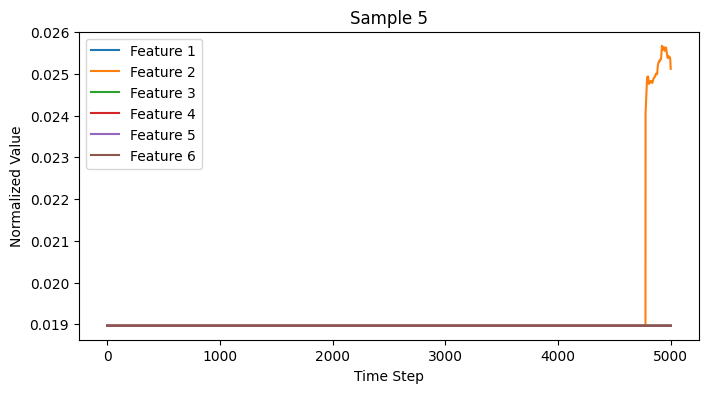

In [27]:
def plot_samples(data_tensor, num_samples_to_plot=5, time_steps=time_steps):
    data_numpy = data_tensor.numpy()

    for sample_index in range(min(num_samples_to_plot, data_tensor.shape[0])):
        plt.figure(figsize=(8, 4))
        for feature_index in range(data_tensor.shape[2]):
            plt.plot(range(time_steps), data_numpy[sample_index, :, feature_index], label=f'Feature {feature_index+1}')
        
        plt.title(f'Sample {sample_index+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.show()

plot_samples(data_tensor, num_samples_to_plot=5, time_steps=time_steps)

## Define and train LSTM-Variational Autoencoder

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        mu = self.fc_mu(hidden[-1])
        logvar = self.fc_logvar(hidden[-1])
        return mu, logvar

class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)
        output, _ = self.lstm(z)
        output = self.fc(output)
        return output

class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(LSTMVAE, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, output_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, seq_length):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, seq_length), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

input_dim = num_features
hidden_dim = 64
latent_dim = 10
output_dim = num_features

model = LSTMVAE(input_dim, hidden_dim, latent_dim, output_dim)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, data_loader, optimizer, num_epochs=40):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(data_loader):
            data = data[0].to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, data.size(1))
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch}, Average Loss: {total_loss / len(data_loader.dataset)}')

train(model, data_loader, optimizer)

Epoch 0, Average Loss: 94.28330326548226
Epoch 1, Average Loss: 7.949718994715722
Epoch 2, Average Loss: 5.853289594828923
Epoch 3, Average Loss: 4.656254768796949
Epoch 4, Average Loss: 3.759056058767967
Epoch 5, Average Loss: 3.240125321682599
Epoch 6, Average Loss: 2.909776193770205
Epoch 7, Average Loss: 2.6449881079577633
Epoch 8, Average Loss: 2.4507434292630785
Epoch 9, Average Loss: 2.3146434004661973
Epoch 10, Average Loss: 2.1785706656517245
Epoch 11, Average Loss: 2.1391715957159234
Epoch 12, Average Loss: 2.0549534958032067
Epoch 13, Average Loss: 2.006932884959851
Epoch 14, Average Loss: 1.9566830388676577
Epoch 15, Average Loss: 1.9337110925103596
Epoch 16, Average Loss: 1.920924574854542
Epoch 17, Average Loss: 1.8640575621619382
Epoch 18, Average Loss: 1.8677532278353566
Epoch 19, Average Loss: 1.8401122546217252
Epoch 20, Average Loss: 1.8328288845671383
Epoch 21, Average Loss: 1.8229043464060877
Epoch 22, Average Loss: 1.823181158671094
Epoch 23, Average Loss: 1.79783

## Plot some generates samples

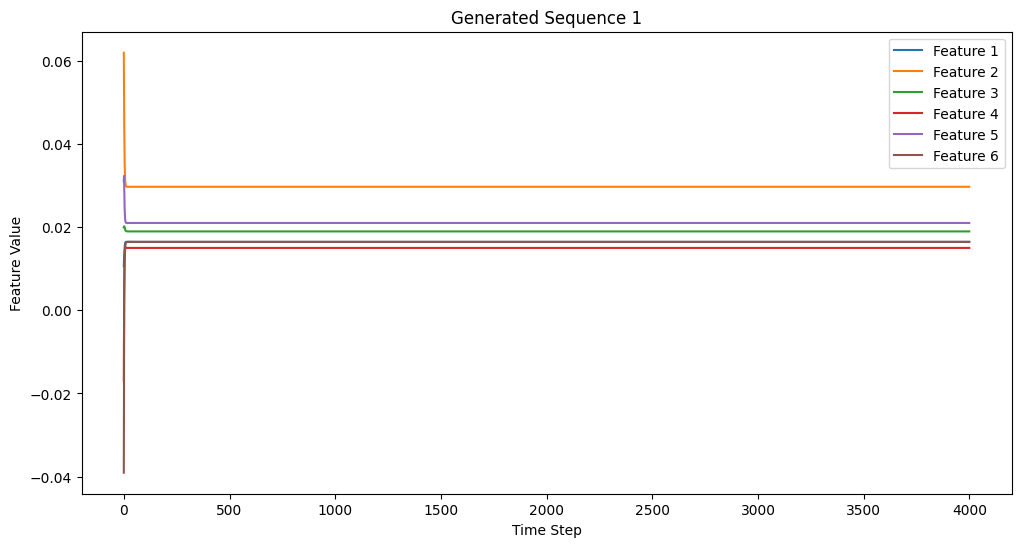

In [5]:
def generate_from_vae(model, num_samples, latent_dim, seq_length):
    model.eval()
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
        generated_sequences = model.decoder(latent_samples, seq_length)      
        return generated_sequences.cpu()

num_samples = 5
seq_length = 4000

generated_data = generate_from_vae(model, num_samples, latent_dim, seq_length)

def plot_generated_data(generated_data, num_sequences_to_plot=5):
    num_features = generated_data.shape[2]

    for i in range(min(num_sequences_to_plot, generated_data.shape[0])):
        plt.figure(figsize=(12, 6))
        for feature_index in range(num_features):
            plt.plot(generated_data[i, :, feature_index], label=f'Feature {feature_index + 1}')
        plt.title(f'Generated Sequence {i + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.show()

plot_generated_data(generated_data, num_sequences_to_plot=1)

## t-SNE Visualization of Latent Space

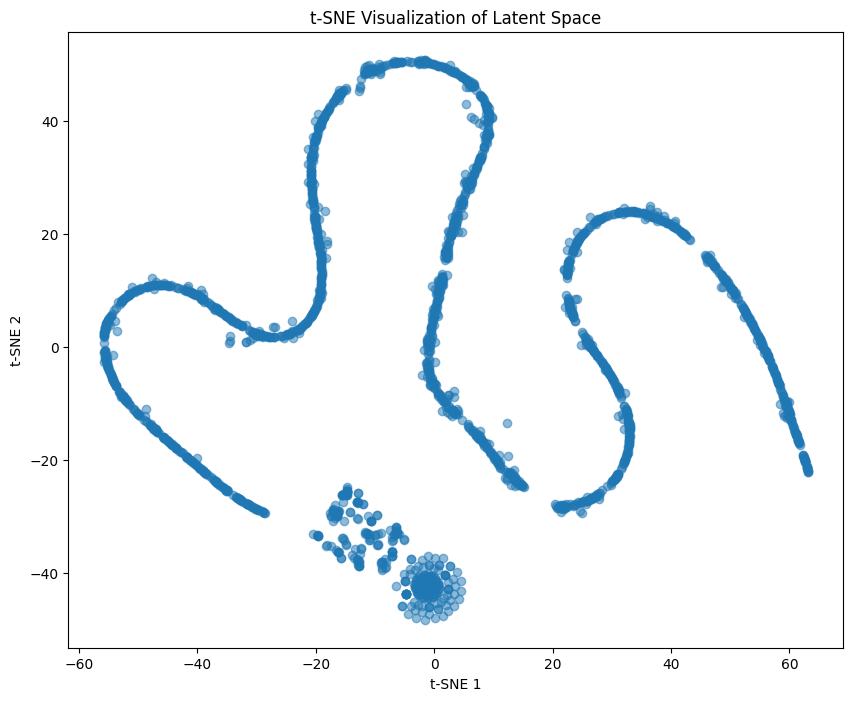

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def extract_latent_variables(model, data_loader):
    model.eval()
    latent_vars = []

    with torch.no_grad():
        for batch in data_loader:
            data = batch[0].to('cuda' if torch.cuda.is_available() else 'cpu')
            mu, _ = model.encoder(data)
            latent_vars.append(mu.cpu().numpy())

    return np.concatenate(latent_vars)

latent_variables = extract_latent_variables(model, data_loader)

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(latent_variables)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## PCA Visualization of Latent Space

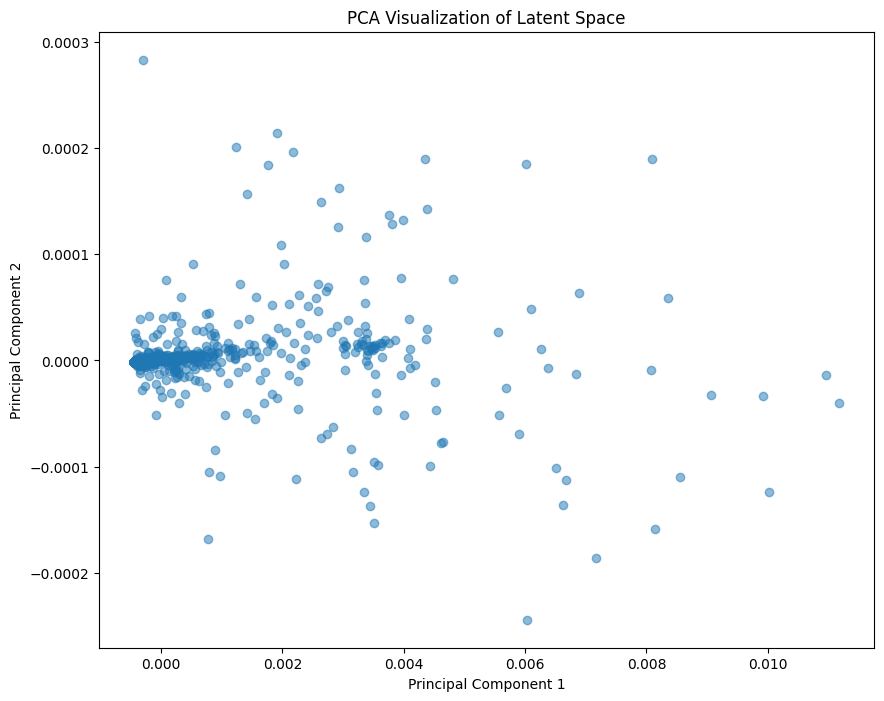

In [7]:
def extract_latent_variables(model, data_loader):
    model.eval()
    latent_vars = []

    with torch.no_grad():
        for batch in data_loader:
            data = batch[0].to('cuda' if torch.cuda.is_available() else 'cpu')
            mu, _ = model.encoder(data)
            latent_vars.append(mu.cpu().numpy())

    return np.concatenate(latent_vars)

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

latent_variables = extract_latent_variables(model, data_loader)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_variables)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA Visualization of Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Use the latent space to compare similarity between two timeseries

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

idx1, idx2 = np.random.choice(len(data_tensor), 2, replace=False)

random_sample_1 = data_tensor[idx1]
random_sample_2 = data_tensor[idx2]

random_sample_1 = random_sample_1.to(device)
random_sample_2 = random_sample_2.to(device)

# Now you can pass the data through the encoder without encountering a device mismatch error
model.eval()
with torch.no_grad():
    encoded_1, _ = model.encoder(random_sample_1.unsqueeze(0))
    encoded_2, _ = model.encoder(random_sample_2.unsqueeze(0))

# After encoding, you can calculate the distance
euclidean_distance = torch.nn.functional.pairwise_distance(encoded_1, encoded_2)

# Print out the distance
print(f"The euclidean distance between the time series in the latent space is: {distance.item()}")


The distance between the time series in the latent space is: 0.0003185915993526578
